# Asymmetric Shortest Path Network Interdiction
We model a shortest path network interdiction (SPNI) game, where the attacker learns the costs of the network.

In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

## Creating a network model
We start by creating a model of the true network and computing its true shortest path.

In [2]:
# Import numpy and ShortestPathGrb class
from numpy import arange, random
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid

In [3]:
# Set hyperparameters for grid generation
m, n = 5, 5  # grid dimensions
numpy_seed = 42  # for reproducibility
pyepo_seed = 135 # for reproducibility

# Set hyperparameters for data generation
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

In [4]:
# Set random seeds
random.seed(numpy_seed)

# Create grid instance
grid = ShortestPathGrid(m, n)

# Create a opt_model instance
opt_model = shortestPathGrb(grid)

Restricted license - for non-production use only - expires 2026-11-23


## Setting Network Arc Weights
We generate the random cost vector using PyEPO's generator and assign it to the grid and opt_model.

In [5]:
import pyepo

# Set parameters for data generation
num_train_data = 10 # number of training data
num_test_data = 0 # number of test data
cost_index = 1 # index of the cost vector to use

In [6]:
# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=pyepo_seed
)

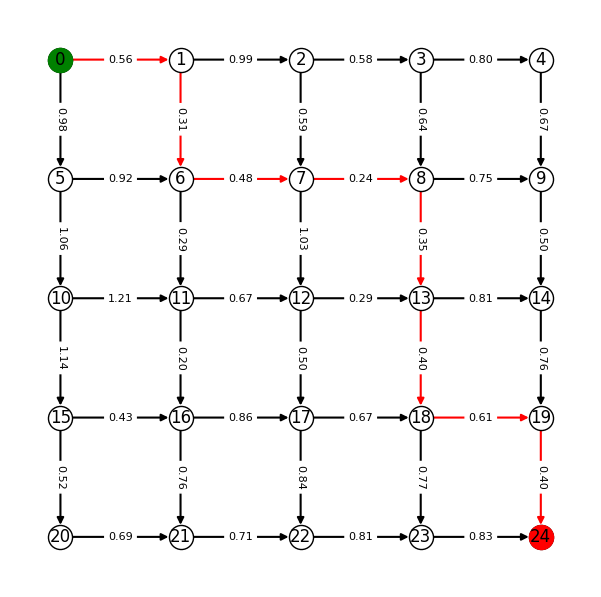

In [7]:
# Choose a cost vector
grid_costs = costs[cost_index]
grid_feats = feats[cost_index]

# Set the cost for the grid (Optionally specify the source and target nodes)
opt_model.setObj(grid_costs)

# Solve shortest path problem
path, obj = opt_model.solve(versatile=True)

## Create data set for parameter learning
We create a data set that a player with insufficient data about the network weights can use to learn. 

In [8]:
# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 100 # number of test data

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=pyepo_seed
)

In [9]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(
    feats, 
    costs, 
    test_size=num_test_data, 
    random_state=42
)

In [10]:
# Create opt_model for attacker
opt_model_est = shortestPathGrb(ShortestPathGrid(m, n))

# Create datasets for training and testing
dataset_train = pyepo.data.dataset.optDataset(opt_model_est, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(opt_model_est, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3485.90it/s]

Optimizing for optDataset...



100%|██████████| 100/100 [00:00<00:00, 3432.44it/s]


In [11]:
# Wrap dataset into PyTorch DataLoader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Train attacker
Next we train a linear regression for the attacker to predict network weights from features.

In [12]:
from src.models.LinearRegression import LinearRegression

# Instantiate linear regression model for prediction
pred_model = LinearRegression(num_feat=num_feat, num_edges=opt_model_est.num_cost)

In [13]:
# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model_est, processes=1)

# Init optimizer
from torch import optim
optimizer = optim.Adam(pred_model.parameters(), lr=1e-2)

Num of cores: 1


In [14]:
from src.models.trainer import Trainer

# Set the number of epochs for training
epochs = 5

# Create a trainer instance
trainer = Trainer(pred_model=pred_model, 
                  opt_model=opt_model_est, 
                  optimizer=optimizer, 
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(loader_train, loader_test, epochs=epochs)

Epoch 00 | Train Loss: 5.2491 | Train Regret: 0.1222 | Test Loss: 1.8140 | Test Regret: 0.1071
Epoch 01 | Train Loss: 1.6856 | Train Regret: 0.0747 | Test Loss: 1.0919 | Test Regret: 0.0755
Epoch 02 | Train Loss: 1.3465 | Train Regret: 0.0703 | Test Loss: 1.0358 | Test Regret: 0.0769
Epoch 03 | Train Loss: 1.3367 | Train Regret: 0.0732 | Test Loss: 1.0087 | Test Regret: 0.0700
Epoch 04 | Train Loss: 1.3330 | Train Regret: 0.0729 | Test Loss: 1.0149 | Test Regret: 0.0749


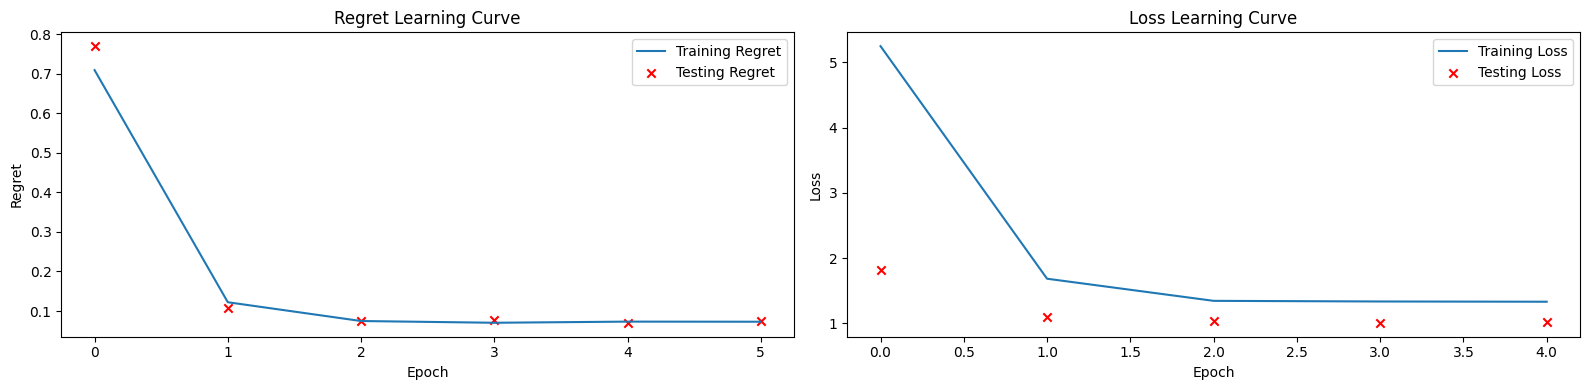

Final regret on test set:  0.07486809342792357


In [15]:
Trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])

## Estimate edge costs form features
We now apply the model for weight estimation and compute an estimated shortest path.

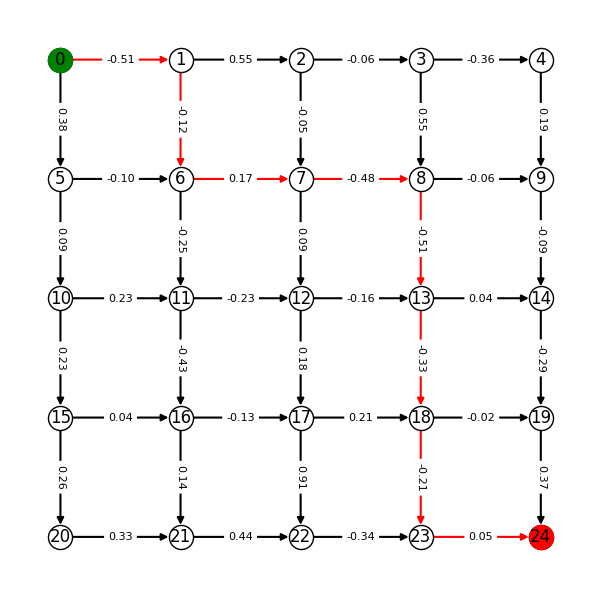

In [16]:
import torch

# Predict costs using the trained model
costs_pred = pred_model(torch.FloatTensor(grid_feats))

# Create a new opt_model instance with the predicted costs
opt_model_est.setObj(costs_pred.detach().numpy())

# Solve the attacker's shortest path problem
path_estimate, obj_estimate = opt_model_est.solve(versatile=True)

In [17]:
# Compare true cost of attacker's shortest path with true cost and true shortest path
print("True cost of attacker's shortest path: ", opt_model.evaluate(path_estimate))
print("True cost of optimal path: ", obj)
# TODO: Print regret?

True cost of attacker's shortest path:  3.9427704011405327
True cost of optimal path:  3.3549304753541946


## Interdictor with full knowledge
We assume the interdictor has full knowledge of network weights and computes its interdiction actions based on that.

In [18]:
# Define the interdiction cost
interdiction_cost = random.rand(grid.num_cost)

# Define Budget
k = 5

# Print the interdiction cost
interdiction_cost

array([0.34106635, 0.11347352, 0.92469362, 0.87733935, 0.25794163,
       0.65998405, 0.8172222 , 0.55520081, 0.52965058, 0.24185229,
       0.09310277, 0.89721576, 0.90041806, 0.63310146, 0.33902979,
       0.34920957, 0.72595568, 0.89711026, 0.88708642, 0.77987555,
       0.64203165, 0.08413996, 0.16162871, 0.89855419, 0.60642906,
       0.00919705, 0.10147154, 0.66350177, 0.00506158, 0.16080805,
       0.54873379, 0.6918952 , 0.65196126, 0.22426931, 0.71217922,
       0.23724909, 0.3253997 , 0.74649141, 0.6496329 , 0.84922341])

In [19]:
from src.solvers.BendersDecomposition import BendersDecomposition

# Initialize the BendersDecomposition with the opt_model
benders = BendersDecomposition(opt_model, k, interdiction_cost, max_cnt=20, eps=1e-3)

In [20]:
interdictions_x, shortest_path_y, z_min = benders.solve()

Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 6.527886083772425, z_min = 3.3549304753541946
Iteration 2: z_max = 5.801930404902185, z_min = 5.075293332338333
Iteration 3: z_max = 5.630670325819105, z_min = 5.418478459119797
Iteration 4: z_max = 5.5141025314239425, z_min = 5.003964319825172
Iteration 5: z_max = 5.418478428790143, z_min = 5.096749171614647
Iteration 6: z_max = 5.418478428790143, z_min = 5.418478459119797
-------------------------------
Found epsilon-optimal solution after 6 iterations with epsilon = -0.00


Original shortest path cost: 	3.35
New shortest path cost: 	5.42


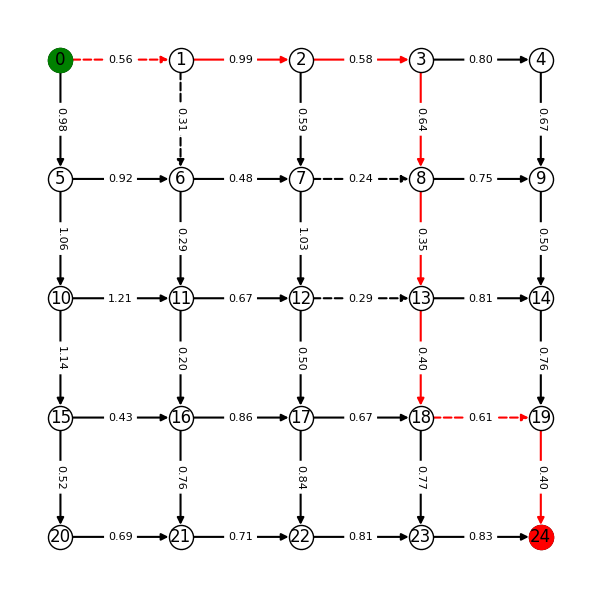

In [21]:
print(f"Original shortest path cost: \t{obj:.2f}\nNew shortest path cost: \t{z_min:.2f}")

opt_model.visualize(colored_edges=shortest_path_y, dashed_edges=interdictions_x)

In [22]:
# Create a new opt_model instance with the interdicted costs
opt_model_interdicted_1 = shortestPathGrb(grid)
opt_model_interdicted_1.setObj(grid_costs + interdiction_cost * interdictions_x)
# Create a new opt_model instance with estimated costs and inderdictions
opt_model_interdicted_1_est = shortestPathGrb(grid)
opt_model_interdicted_1_est.setObj(costs_pred.detach().numpy() + interdiction_cost * interdictions_x)

Interdicted shortest path cost with estimated weights: 	5.52


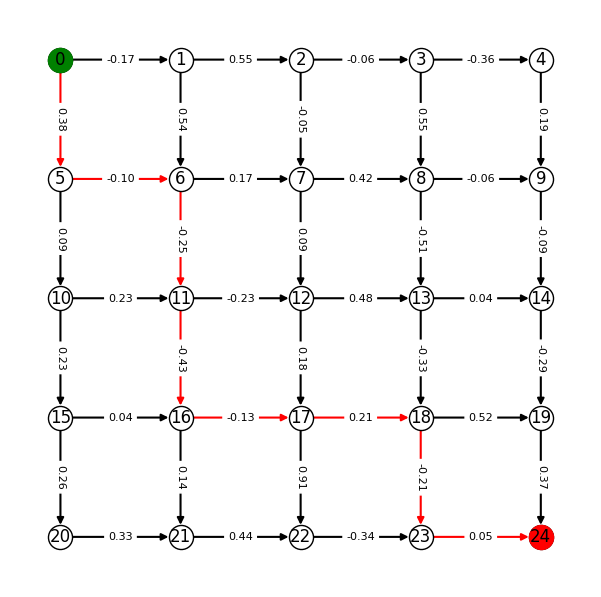

In [23]:
# Calculate the shortest paths with and without full knowledge
path_interdicted_1 = shortest_path_y
path_interdicted_1_est, obj_interdicted_1_est = opt_model_interdicted_1_est.solve(versatile=True)

print(f"Interdicted shortest path cost with estimated weights: \t{opt_model_interdicted_1.evaluate(path_interdicted_1_est):.2f}")

## Interdictor with limited knowledge
We now assume that the interdictor does not have full network knowledge and that it uses the learned linear regression for arc weight estimation.

In [24]:
# Initialize the BendersDecomposition with the attacker_opt_model
benders_est = BendersDecomposition(opt_model_est, k, interdiction_cost, max_cnt=20, eps=1e-3)

In [25]:
interdictions_x_2, shortest_path_y_2, z_min_2 = benders_est.solve()

Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 1.9030557894626616, z_min = -1.9415023252367973
Iteration 2: z_max = 0.5177778363074601, z_min = -0.6031640619039536
Iteration 3: z_max = 0.4649208895378867, z_min = 0.019353248178958893
Iteration 4: z_max = 0.15279838990583006, z_min = -0.18826796114444733
Iteration 5: z_max = 0.14600319426096586, z_min = -0.24259503930807114
Iteration 6: z_max = 0.07693208160621468, z_min = -0.21148162335157394
Iteration 7: z_max = 0.07693208160621468, z_min = -0.652427613735199
Iteration 8: z_max = 0.07693208160621468, z_min = -0.5191477909684181
Iteration 9: z_max = 0.019353248178978266, z_min = -0.013187311589717865
Iteration 10: z_max = 0.019353248178978266, z_min = 0.019353248178958893
-------------------------------
Found epsilon-optimal solution after 10 iterations with epsilon = 0.00


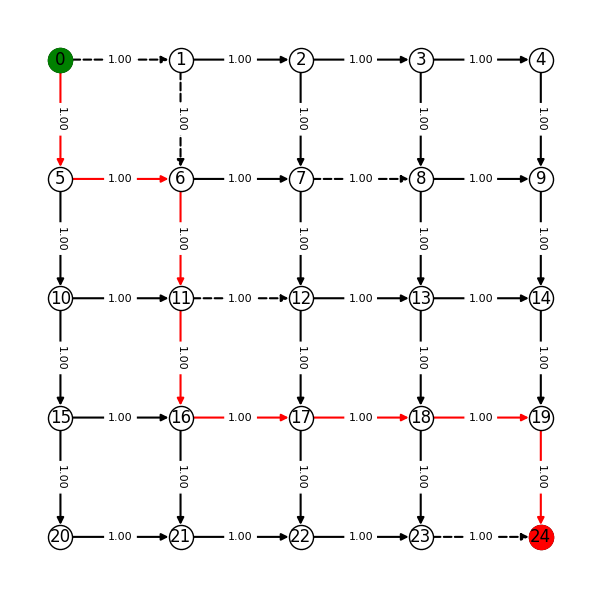

In [26]:
grid.visualize(colored_edges=shortest_path_y_2, dashed_edges=interdictions_x_2)

In [27]:
# Create a new opt_model instance with the interdicted costs
opt_model_interdicted_2 = shortestPathGrb(grid)
opt_model_interdicted_2.setObj(grid_costs + interdiction_cost * interdictions_x_2)

# Create a new opt_model instance with the estimated costs and interdictions
opt_model_interdicted_2_est = shortestPathGrb(grid)
opt_model_interdicted_2_est.setObj(costs_pred.detach().numpy() + interdiction_cost * interdictions_x_2)

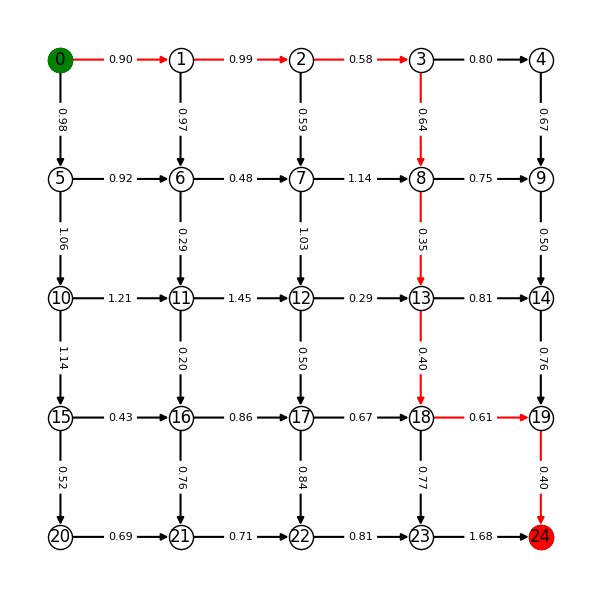

In [28]:
# Calculate the shortest paths with and without full knowledge
path_interdicted_2, obj_interdicted_2 = opt_model_interdicted_2.solve(versatile=True)
path_interdicted_2_est = shortest_path_y_2

In [29]:
from tabulate import tabulate

# table_with_attacker = [[
#         "Game Setup", 
#         "True Attacker Path Cost", 
#         "Estimated Attacker Path Cost", 
#         "True Attacker Path Cost (Interdicted)", 
#         "Estimated Attacker Path Cost (Interdicted)"
#     ], [
#         "B1 + A1", 
#         obj, opt_model.evaluate(path), 
#         z_min, 
#         z_min
#     ], [
#         "B1 + A2", 
#         opt_model.evaluate(path_estimate), 
#         obj_estimate, 
#         z_min, 
#         opt_model_est.evaluate(shortest_path_y) + interdictions_x @ interdiction_cost
#     ], [
#         "B2 + A2", 
#         opt_model.evaluate(path_estimate), 
#         obj_estimate, 
#         opt_model.evaluate(shortest_path_y) + interdictions_x_2 @ interdiction_cost, z_min_2
#     ]
# ]

table = [[
        "Game Setup", 
        "True Attacker Path Cost", 
        "True Attacker Path Cost (Interdicted)"
    ], [
        "I1 + E1", 
        obj, 
        opt_model_interdicted_1.evaluate(shortest_path_y)
    ], [
        "I1 + E2", 
        opt_model.evaluate(path_estimate), 
        opt_model_interdicted_1.evaluate(path_interdicted_1_est)
    ], [
        "I2 + E2", 
        opt_model.evaluate(path_estimate), 
        opt_model_interdicted_2.evaluate(path_interdicted_2_est)
    ], [
        "I2 + E1",
        obj,
        opt_model_interdicted_2.evaluate(path_interdicted_2)
    ]
]

print("Results of simulating the interdictor and evader with different graph knowledge:")
print("\tI1 and I2 are the interdictor with and without knowledge of the graph, respectively.")
print("\tE1 and E2 are the evader with and without knowledge of the graph, respectively.")

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Results of simulating the interdictor and evader with different graph knowledge:
	I1 and I2 are the interdictor with and without knowledge of the graph, respectively.
	E1 and E2 are the evader with and without knowledge of the graph, respectively.
╒══════════════╤═══════════════════════════╤═════════════════════════════════════════╕
│ Game Setup   │   True Attacker Path Cost │   True Attacker Path Cost (Interdicted) │
╞══════════════╪═══════════════════════════╪═════════════════════════════════════════╡
│ I1 + E1      │                   3.35493 │                                 5.41848 │
├──────────────┼───────────────────────────┼─────────────────────────────────────────┤
│ I1 + E2      │                   3.94277 │                                 5.51841 │
├──────────────┼───────────────────────────┼─────────────────────────────────────────┤
│ I2 + E2      │                   3.94277 │                                 4.93057 │
├──────────────┼───────────────────────────┼────────────